# Variational Image Domain Analysis

Imaging is one of the first steps in imaging. After you want to move from image domain to feature domain. By features, we mean image structures that are *interesting*. For example, in the analysis of M87 we were interested in the diameter, width, brightness position angle and asymmetry. 

VIDA is a generic tools specifically designed to work with the EHT and its images. In this notebook we will demonstrate how to use VIDA to extract quantitative image feature estimates from the image you just created.

In [1]:
# This creates a local environment in Julia so you can explore a number of things
using Pkg; Pkg.activate(@__DIR__)

  Activating environment at `~/Research/Projects/ngEHT/ngEHT2021-Tutorial/Project.toml`


In [2]:
# Now lets instiate our environment to match the one used to create this notebook!
Pkg.instantiate()

# If you wanted to add VIDA you could also do
# Pkg.add("VIDA")
# For plots
# Pkg.add("Plots")

In [3]:
# Load the packages
using VIDA
using Plots

## Loading the image and deciding on image features

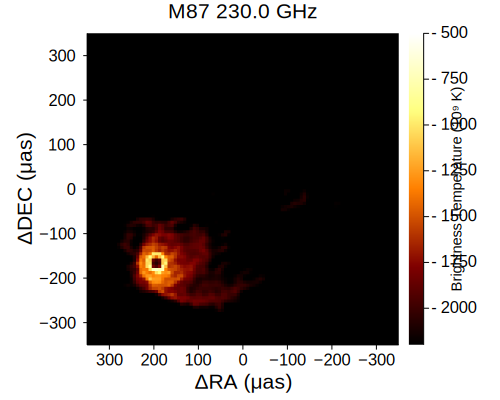

In [4]:
img = load_image("results/M87_ngeht_ref1_230_thnoise.fits")

#Make the image log-scale so we can see the jet base.
plot(log10.(img./flux(img)), clims=(-2200, -500))

## Deciding on a template

VIDA is basically a template matching algorithm. Which mean we need to decide on the specific image structure we want to extract. In this image there are two components

1. The ring
2. The jet or larger Gaussian structure

For 1 we will use the `SymCosineRing` template. To see its detail please see the docs or pull them up using Julia's help.

For 2 we will use the `AsymGaussian` template. This is a asymmetric Gaussian template. 

Finally we will include a `Constant` filter to deal with the low level diffuse flux the commonly appears in these image reconstructions

To stack templates, VIDA has overloaded the `+` operator to construct a composite model. To construct our template we do:

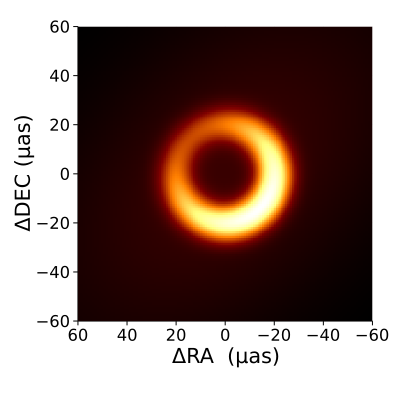

In [5]:
# The ring is rather simple so lets use a 0,2 cosine ring
template = SymCosineRing{0,2}(r0 = 20.0, #ring radius in μas
                              σ = [5.0], #ring width in μas
                              ξσ = [], # Empty because N=0 so no expansion in width
                              s = [0.5, 0.0], # brightness cosine expansion amplitdues
                              ξs = [-3π/4, 0.0], # brightness cosine expansion phases
                              x0 = 0.0, #ring center in RA
                              y0 = 0.0  #rin center in DEC
                             ) + 
                        0.2*AsymGaussian(σ=50.0, τ=0.4, ξ=-π/4, x0=0.0, y0=0.0) + 0.1*Constant()
# Plots the template
plot(template)

Now let's fit the template! To do this we need to define our boundaries. We will do this by specifying the upper and lower template

In [6]:
upper = SymCosineRing{0,2}(r0 = 60.0, #ring radius
                              σ = [40.0], #ring width
                              ξσ = [], # Empty because N=0 so no expansion in width
                              s = [0.99, 1.0], # brightness cosine expansion amplitdues
                              ξs = [1π, 1π], # brightness cosine expansion phases
                              x0 = 300.0,
                              y0 = 300.0
                             ) + 1.0*AsymGaussian(σ=500.0, τ=0.99, ξ=π/2, x0=400.0, y0=400.0) + 0.5*Constant()
lower = SymCosineRing{0,2}(r0 = 10.0, #ring radius
                              σ = [0.1], #ring width
                              ξσ = [], # Empty because N=0 so no expansion in width
                              s = [0.01, -1.0], # brightness cosine expansion amplitdues
                              ξs = [-π, -π], # brightness cosine expansion phases
                              x0 = -300.0,
                              y0 = -300.0
                             ) + 1e-6*AsymGaussian(σ=5.0, τ=0.01, ξ=-π/2, x0=-400.0, y0=-400.0) + 1e-8*Constant()

VIDA.AddTemplate{VIDA.AddTemplate{SymCosineRing{0, 2}, VIDA.MulTemplate{AsymGaussian, Float64}}, VIDA.MulTemplate{Constant, Float64}}(VIDA.AddTemplate{SymCosineRing{0, 2}, VIDA.MulTemplate{AsymGaussian, Float64}}(SymCosineRing{0, 2}
  r0: Float64 10.0
  σ: Array{Float64}((1,)) [0.1]
  ξσ: Array{Float64}((0,)) Float64[]
  s: Array{Float64}((2,)) [0.01, -1.0]
  ξs: Array{Float64}((2,)) [-3.141592653589793, -3.141592653589793]
  x0: Float64 -300.0
  y0: Float64 -300.0
, VIDA.MulTemplate{AsymGaussian,Float64}
θ: AsymGaussian
  σ: Float64 5.0
  τ: Float64 0.01
  ξ: Float64 -1.5707963267948966
  x0: Float64 -400.0
  y0: Float64 -400.0
Irel: Float64 1.0e-6
), VIDA.MulTemplate{Constant,Float64}
θ: Constant()Irel: Float64 1.0e-8
)

## Selecting the divergence

VIDA uses probability divergences as its cost function. There are a number of different divergences implemented. To see them we can use the `subtypes(VIDA.AbstractDivergence)` method

In [7]:
subtypes(VIDA.AbstractDivergence)

4-element Vector{Any}:
 Bhattacharyya
 KullbackLeibler
 LeastSquares
 Renyi

 For this problem we will use the Renyi divergence, let's take a look at the docstring

In [11]:
?Renyi

search: Renyi ReadOnlyMemoryError isreadonly TransparentGray



```
Renyi(img::EHTImage, α)
```

Construct the Renyi divergence with parameter α. It constructed from an `EHTImage` i.e. data.

### Details

This computes the KL divergence which is related to Hellinger distance between two distributions. In fact, they are both minimized at the same point. The Bhattacharyya divergence is defined as

$$
Ry(f_\theta||\hat{I}) = \frac{1}{α-1}\log\int log
        \left(\frac{f_{\theta}(x,y)^\alpha}{\hat{I}(x,y)^{\alpha-1}}\right)dxdy,
$$

where $\hat{I}$ is defined as the image normalized to unit flux.

This is a very flexible divergence that reduces to many of the other divergences implemented.

  * `α = 1` corresponds to the KL divergence
  * `α = 1/2` corresponds to the Bhattacharyya divergence up to a multiplicative factor of 2

Typically we find that `α=1.5` works well, as it focusses on the bright regions of the images moreso than the Bh and KL divergence. For `α>2` the measure tends to devolve in something akin the to sup norm and fails to match the image structure.


In [9]:
bh = Renyi(img, 1.5)

Renyi{EHTImage{Float64, Matrix{Float64}}, Float64}([5.8307343678454174e-8 7.048651867918633e-8 … 4.3387264098439613e-11 2.6057231904058662e-11; 7.051288705744571e-8 8.532831149853831e-8 … 7.050143081054508e-11 4.3308679728756146e-11; … ; 4.366545234888053e-11 7.084820022222649e-11 … 7.209641795655416e-11 4.424505920648843e-11; 2.61821017858045e-11 4.345771894914635e-11 … 4.42302739882524e-11 2.6546686553652826e-11], 0.7629558866636356, 1.5)

In [18]:
# Now construct the optimization problem

prob = ExtractProblem(bh, template, lower, upper)

# Now find the minimum using the BBO optimizer

#Threaded extractor will split the problem into the number of threads you started julia with
#Since we are using a default IJulia environment this will be single threaded. To use multiple threads
#see this github issue https://github.com/JuliaLang/IJulia.jl/issues/882
opt, divmin = threaded_extractor(4, prob, BBO(;maxevals=25_000))

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.50 secs, 215 evals, 130 steps, improv/step: 0.385 (last = 0.3846), fitness=2.925396925
1.00 secs, 439 evals, 303 steps, improv/step: 0.393 (last = 0.3988), fitness=2.592649329
1.50 secs, 662 evals, 515 steps, improv/step: 0.388 (last = 0.3821), fitness=2.315997132
2.01 secs, 889 evals, 742 steps, improv/step: 0.333 (last = 0.2070), fitness=2.179525318
2.51 secs, 1116 evals, 969 steps, improv/step: 0.295 (last = 0.1718), fitness=2.179525318
3.01 secs, 1343 evals, 1196 steps, improv/step: 0.288 (last = 0.2555), fitness=1.874389801
3.51 secs, 1569 evals, 1422 steps, improv/step: 0.280 (last = 0.2389), fitness=1.858463777
4.01 secs, 1796 evals, 1649 steps, improv/step: 0.269 (last = 0.2026), fitness=1.837028949
4.51 se

43.59 secs, 19408 evals, 19261 steps, improv/step: 0.178 (last = 0.2178), fitness=0.671775465
44.10 secs, 19634 evals, 19487 steps, improv/step: 0.177 (last = 0.1681), fitness=0.671775465
44.60 secs, 19859 evals, 19712 steps, improv/step: 0.178 (last = 0.2311), fitness=0.671775465
45.10 secs, 20084 evals, 19937 steps, improv/step: 0.178 (last = 0.1600), fitness=0.670969006
45.60 secs, 20309 evals, 20162 steps, improv/step: 0.178 (last = 0.2267), fitness=0.670665146
46.10 secs, 20534 evals, 20387 steps, improv/step: 0.179 (last = 0.2133), fitness=0.669459242
46.60 secs, 20735 evals, 20588 steps, improv/step: 0.179 (last = 0.2338), fitness=0.666121126
47.11 secs, 20950 evals, 20803 steps, improv/step: 0.179 (last = 0.1953), fitness=0.665825748
47.61 secs, 21176 evals, 21029 steps, improv/step: 0.180 (last = 0.2257), fitness=0.665557869
48.11 secs, 21402 evals, 21255 steps, improv/step: 0.180 (last = 0.1726), fitness=0.665060548
48.61 secs, 21628 evals, 21481 steps, improv/step: 0.181 (la

27.55 secs, 12061 evals, 11916 steps, improv/step: 0.201 (last = 0.1991), fitness=0.800615084
28.05 secs, 12270 evals, 12125 steps, improv/step: 0.201 (last = 0.2249), fitness=0.799754659
28.56 secs, 12495 evals, 12350 steps, improv/step: 0.201 (last = 0.1644), fitness=0.799136231
29.06 secs, 12709 evals, 12564 steps, improv/step: 0.200 (last = 0.1589), fitness=0.795288880
29.56 secs, 12929 evals, 12784 steps, improv/step: 0.200 (last = 0.1909), fitness=0.795288880
30.06 secs, 13140 evals, 12995 steps, improv/step: 0.198 (last = 0.1137), fitness=0.795288880
30.56 secs, 13360 evals, 13215 steps, improv/step: 0.197 (last = 0.1364), fitness=0.794335866
31.06 secs, 13584 evals, 13439 steps, improv/step: 0.197 (last = 0.1429), fitness=0.754113315
31.56 secs, 13766 evals, 13621 steps, improv/step: 0.196 (last = 0.1868), fitness=0.754113315
32.06 secs, 13974 evals, 13829 steps, improv/step: 0.196 (last = 0.1683), fitness=0.754113315
32.56 secs, 14166 evals, 14021 steps, improv/step: 0.195 (la

10.53 secs, 4606 evals, 4499 steps, improv/step: 0.249 (last = 0.1794), fitness=1.051753915
11.03 secs, 4830 evals, 4723 steps, improv/step: 0.246 (last = 0.1964), fitness=1.051753915
11.53 secs, 5054 evals, 4947 steps, improv/step: 0.244 (last = 0.1830), fitness=0.965088969
12.03 secs, 5273 evals, 5166 steps, improv/step: 0.241 (last = 0.1826), fitness=0.965088969
12.53 secs, 5465 evals, 5358 steps, improv/step: 0.240 (last = 0.2135), fitness=0.946593520
13.03 secs, 5661 evals, 5554 steps, improv/step: 0.238 (last = 0.1939), fitness=0.905577794
13.53 secs, 5867 evals, 5760 steps, improv/step: 0.235 (last = 0.1359), fitness=0.905577794
14.03 secs, 6068 evals, 5961 steps, improv/step: 0.234 (last = 0.2040), fitness=0.866887695
14.54 secs, 6271 evals, 6164 steps, improv/step: 0.232 (last = 0.1823), fitness=0.866887695
15.04 secs, 6475 evals, 6368 steps, improv/step: 0.230 (last = 0.1716), fitness=0.866887695
15.54 secs, 6682 evals, 6575 steps, improv/step: 0.229 (last = 0.2077), fitness=

54.63 secs, 23750 evals, 23643 steps, improv/step: 0.193 (last = 0.1810), fitness=0.354597379
55.13 secs, 23972 evals, 23865 steps, improv/step: 0.192 (last = 0.1802), fitness=0.354597379
55.64 secs, 24156 evals, 24049 steps, improv/step: 0.192 (last = 0.2011), fitness=0.354369851
56.14 secs, 24357 evals, 24250 steps, improv/step: 0.193 (last = 0.2786), fitness=0.354067013
56.64 secs, 24583 evals, 24476 steps, improv/step: 0.193 (last = 0.2124), fitness=0.353761715
57.14 secs, 24808 evals, 24701 steps, improv/step: 0.194 (last = 0.2267), fitness=0.353635758

Optimization stopped after 24894 steps and 57.57 seconds
Termination reason: Max number of function evaluations (25000) reached
Steps per second = 432.44
Function evals per second = 434.30
Improvements/step = Inf
Total function evaluations = 25001


Best candidate found: [18.269, 2.68259, 0.544484, 0.225955, -1.79326, 2.7081, 192.334, -162.755, 51.753, 0.185124, 0.442529, 162.471, -167.483, 0.0266994, 2.01103e-5]

Fitness: 0.353618

38.08 secs, 16907 evals, 16808 steps, improv/step: 0.191 (last = 0.1525), fitness=0.668574228
38.58 secs, 17130 evals, 17031 steps, improv/step: 0.191 (last = 0.1480), fitness=0.668149436
39.08 secs, 17354 evals, 17255 steps, improv/step: 0.190 (last = 0.1473), fitness=0.667482168
39.58 secs, 17579 evals, 17480 steps, improv/step: 0.190 (last = 0.1600), fitness=0.666689033
40.08 secs, 17802 evals, 17703 steps, improv/step: 0.189 (last = 0.1480), fitness=0.666689033
40.59 secs, 18026 evals, 17927 steps, improv/step: 0.189 (last = 0.2098), fitness=0.666308291
41.09 secs, 18247 evals, 18148 steps, improv/step: 0.189 (last = 0.1493), fitness=0.665602191
41.59 secs, 18445 evals, 18346 steps, improv/step: 0.189 (last = 0.1717), fitness=0.665385948
42.09 secs, 18661 evals, 18562 steps, improv/step: 0.189 (last = 0.1944), fitness=0.664950325
42.59 secs, 18863 evals, 18764 steps, improv/step: 0.189 (last = 0.2030), fitness=0.664611750
43.09 secs, 19072 evals, 18973 steps, improv/step: 0.189 (la

(VIDA.AddTemplate{VIDA.AddTemplate{SymCosineRing{0, 2}, VIDA.MulTemplate{AsymGaussian, Float64}}, VIDA.MulTemplate{Constant, Float64}}(VIDA.AddTemplate{SymCosineRing{0, 2}, VIDA.MulTemplate{AsymGaussian, Float64}}(SymCosineRing{0, 2}
  r0: Float64 18.268979301978927
  σ: Array{Float64}((1,)) [2.6825913576282634]
  ξσ: Array{Float64}((0,)) Float64[]
  s: Array{Float64}((2,)) [0.5444838821031442, 0.22595543502043114]
  ξs: Array{Float64}((2,)) [-1.7932608064188222, 2.708100249911982]
  x0: Float64 192.33356270304435
  y0: Float64 -162.75505525422375
, VIDA.MulTemplate{AsymGaussian,Float64}
θ: AsymGaussian
  σ: Float64 51.7530050089016
  τ: Float64 0.18512356180764264
  ξ: Float64 0.4425291931904549
  x0: Float64 162.47083449325584
  y0: Float64 -167.4831750705623
Irel: Float64 0.026699444278139025
), VIDA.MulTemplate{Constant,Float64}
θ: Constant()Irel: Float64 2.0110269539484633e-5
), 0.3536183279408111)

Now lets evaluate the results!

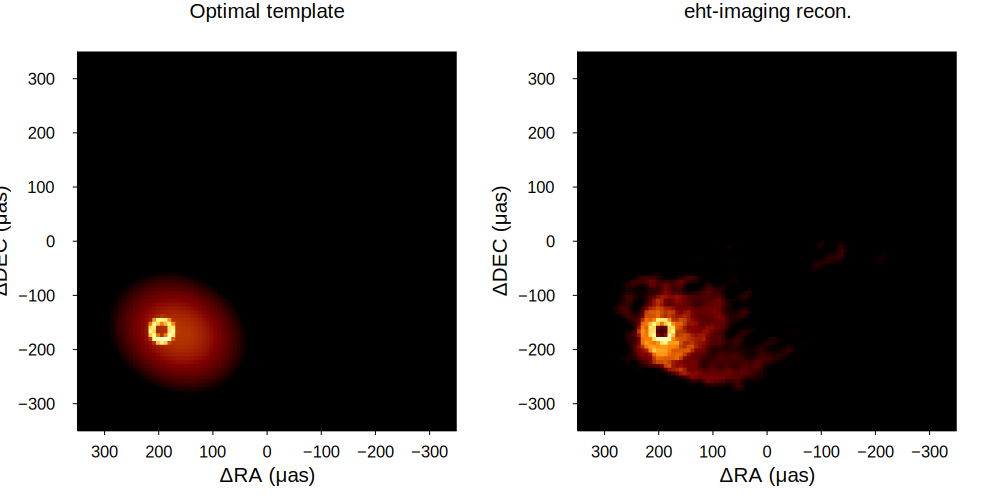

In [19]:
# Create an image object from the optimal template
optimg = VIDA.make_image(opt, 100, (-350, 350), (-350,350))

p1 = plot(log10.(optimg./flux(optimg)), clims=(-2250, -500), colorbar=:none, title="Optimal template")
p2 = plot(log10.(img./flux(img)), clims=(-2250, -500), colorbar=:none, title = "eht-imaging recon.")
plot(p1, p2, layout=(1,2), size=(1000, 500))

Well from that is looks like we are doing a decent job! What are the ring parameters?

In [20]:
# SPlit the template object into components and extract the ring which is the first one
ropt = split(opt)[1]

SymCosineRing{0, 2}
  r0: Float64 18.268979301978927
  σ: Array{Float64}((1,)) [2.6825913576282634]
  ξσ: Array{Float64}((0,)) Float64[]
  s: Array{Float64}((2,)) [0.5444838821031442, 0.22595543502043114]
  ξs: Array{Float64}((2,)) [-1.7932608064188222, 2.708100249911982]
  x0: Float64 192.33356270304435
  y0: Float64 -162.75505525422375


In [21]:
# Plot just the ring

p1 = plot(optimg./flux(optimg), colorbar=:none, title="Optimal template")
xlims!(p1, ropt.x0-2*ropt.r0, ropt.x0+2*ropt.r0)
ylims!(p1, ropt.y0-2*ropt.r0, ropt.y0+2*ropt.r0)

p2 = plot(img./flux(img), colorbar=:none, title = "eht-imaging recon.")
xlims!(p2, ropt.x0-2*ropt.r0, ropt.x0+2*ropt.r0)
ylims!(p2, ropt.y0-2*ropt.r0, ropt.y0+2*ropt.r0)

plot(p1, p2, layout=(1,2), size=(1000, 500))
